# 샘플 불러오기

Sample rate: 22050
Signal shape: (117601,)


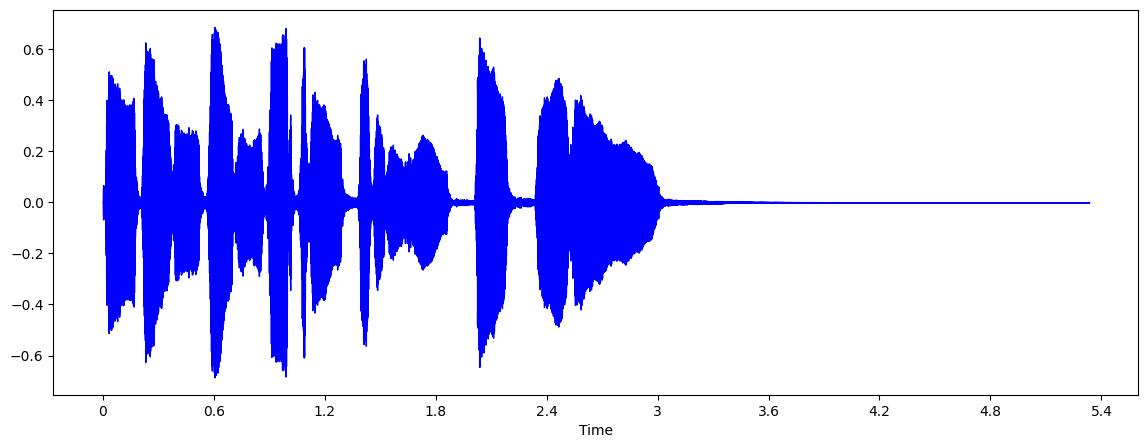

In [1]:
import librosa
import matplotlib.pyplot as plt

# 트럼펫 샘플 불러오기
y, sr = librosa.load(librosa.ex('trumpet'))

# 기본 정보 확인
print(f'Sample rate: {sr}')
print(f'Signal shape: {y.shape}')


fig = plt.figure(figsize = (14,5))
librosa.display.waveshow(y, sr=sr, color="blue")

# STFT 수행

STFT Shape: (513, 230)


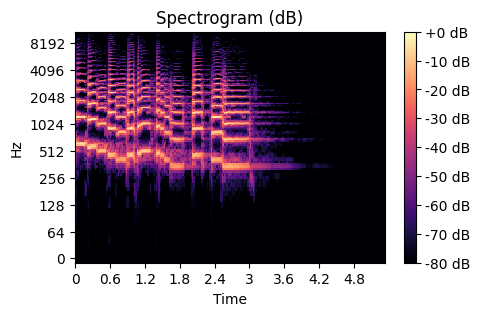

In [2]:
import numpy as np

# STFT 수행
D = librosa.stft(y, n_fft=1024, hop_length=512, window='hann')

# 복소수 출력됨 (실수부+허수부)
print(f'STFT Shape: {D.shape}')  # (frequency_bins, time_frames)

# 진폭 스펙트럼을 dB로 변환 (시각화 편의)
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# 시각화
plt.figure(figsize=(5, 3))
librosa.display.specshow(D_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram (dB)')
plt.show()

# 들어서 비교해보자

In [3]:
from IPython.display import Audio

# 오디오 플레이어 출력
Audio(y, rate=sr)


# Mel Filter Bank 구현

In [4]:
import numpy as np

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def mel_filter_bank(num_filters, fft_size, sample_rate, f_min=300, f_max=8000):
    # Step 1: 주파수 범위 설정
    nyquist = sample_rate / 2
    f_max = min(f_max, nyquist)

    # Step 2: Hz -> Mel 변환
    mel_min = hz_to_mel(f_min)
    mel_max = hz_to_mel(f_max)

    # Step 3: 멜 스케일에 등간격으로 필터 중심 배치
    mel_points = np.linspace(mel_min, mel_max, num_filters + 2)
    hz_points = mel_to_hz(mel_points)

    # Step 4: Hz를 FFT bin index로 변환
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    # Step 5: 각 필터를 삼각형으로 구성
    filters = np.zeros((num_filters, fft_size // 2 + 1))

    for m in range(1, num_filters + 1):
        left = bin_points[m - 1]
        center = bin_points[m]
        right = bin_points[m + 1]

        for k in range(left, center):
            filters[m-1, k] = (k - left) / (center - left)
        for k in range(center, right):
            filters[m-1, k] = (right - k) / (right - center)
    return filters

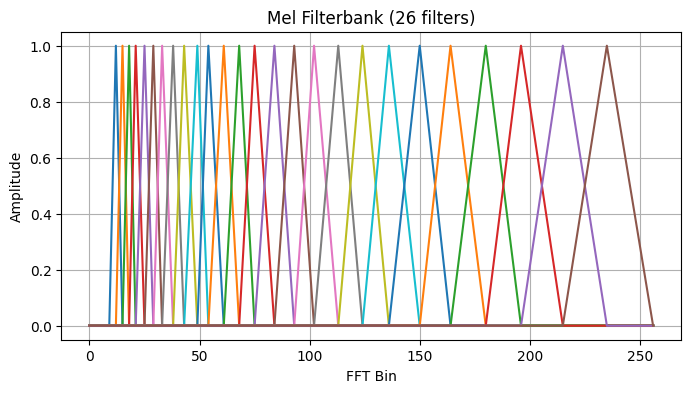

In [5]:
import matplotlib.pyplot as plt

sample_rate = 16000
fft_size = 512
num_filters = 26

filters = mel_filter_bank(num_filters, fft_size, sample_rate)

plt.figure(figsize=(8, 4))
for i in range(num_filters):
    plt.plot(filters[i])
plt.title('Mel Filterbank (26 filters)')
plt.xlabel('FFT Bin')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


# Mel Spectogram

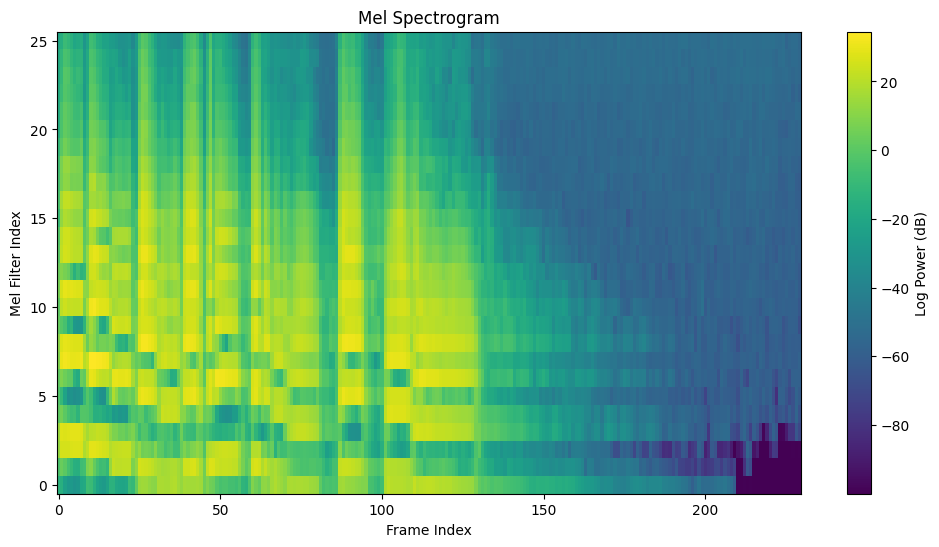

In [6]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# 트럼펫 샘플 불러오기
y, sr = librosa.load(librosa.ex('trumpet'))
# STFT 수행
D = librosa.stft(y, n_fft=1024, hop_length=512, window='hann')

power_spectrum = np.abs(D)**2  # 크기의 제곱으로 파워 스펙트럼 구함

num_filters = 26
filters = mel_filter_bank(num_filters, 1024, sr)
mel_spectrum = np.dot(filters, power_spectrum)  # (26, 프레임 수)

plt.figure(figsize=(12,6))
plt.imshow(10 * np.log10(mel_spectrum + 1e-10), aspect='auto', origin='lower')
plt.colorbar(label='Log Power (dB)')
plt.title('Mel Spectrogram')
plt.xlabel('Frame Index')
plt.ylabel('Mel Filter Index')
plt.show()


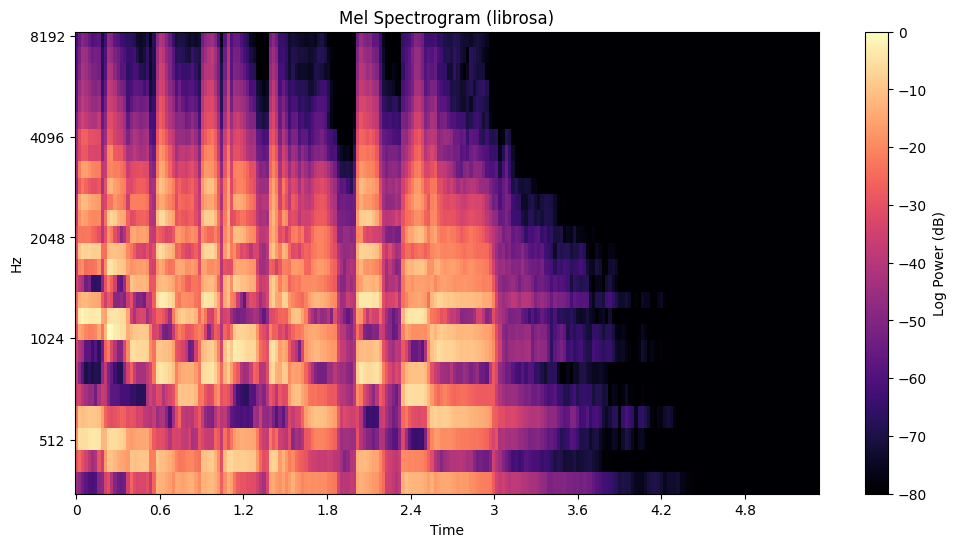

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 트럼펫 샘플 불러오기
y, sr = librosa.load(librosa.ex('trumpet'))

# 멜 스펙트로그램 계산
mel_spec = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=26, fmin=300, fmax=8000
)

# 로그 스케일 (dB로 변환)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# 시각화
plt.figure(figsize=(12,6))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=300, fmax=8000)
plt.colorbar(label='Log Power (dB)')
plt.title('Mel Spectrogram (librosa)')
plt.show()


# DCT 통한 MFCC 추출

In [8]:
import scipy
mfcc_scipy = scipy.fftpack.dct(log_mel_spec, type=2, axis=0, norm='ortho')
mfcc_scipy.shape

(26, 230)

In [9]:
mfcc_librosa = librosa.feature.mfcc(
    y=y,
    sr=sr,
    n_fft=1024,
    hop_length=512,
    n_mfcc=13,
    n_mels=26,
    fmin=300,
    fmax=8000,
)
mfcc_librosa.shape

(13, 230)

In [10]:
np.testing.assert_almost_equal(mfcc_librosa[1:], mfcc_scipy[1:13, :], decimal=4)